In [108]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline

import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer
from sklearn.metrics import f1_score, precision_recall_fscore_support
import pandas as pd
import scipy.stats as ss

import matplotlib.pyplot as plt

Data-reuploading classifier
===========================

*Author: Shahnawaz Ahmed (<shahnawaz.ahmed95@gmail.com>). Last updated:
19 Jan 2021.*

A single-qubit quantum circuit which can implement arbitrary unitary
operations can be used as a universal classifier much like a single
hidden-layered Neural Network. As surprising as it sounds,
[Pérez-Salinas et al. (2019)](https://arxiv.org/abs/1907.02085) discuss
this with their idea of 'data reuploading'. It is possible to load a
single qubit with arbitrary dimensional data and then use it as a
universal classifier.


In [5]:
#Open and Read Dataset
import h5py

filename = "../data_apertif.hdf5"
with h5py.File(filename, "r") as f:
    # Print all root level object names (aka keys) 
    # these can be group or dataset names 
    print("Keys: %s" % f.keys())
    # get first object name/key; may or may NOT be a group
    a_group_key = list(f.keys())[2]
    labels = f[a_group_key][()]

    a_group_key = list(f.keys())[1]
    data = f[a_group_key][()] 

Keys: <KeysViewHDF5 ['data_dm_time', 'data_freq_time', 'labels', 'multibeam_snr', 'params', 'snr']>


In [7]:
#Sub-sample data to feed in to classifier
data_subset = data[0::60,:,:] 
labels_subset = labels[0::60]
print (data_subset.shape, labels_subset.shape)

(1120, 32, 250) (1120,)


In [8]:
#Subtract median in the frequency channel
data_wo_median = np.zeros(data_subset.shape)
median = np.median(data_subset, axis=1)
data_wo_median = data_subset - median[:, np.newaxis,:]

#Divide by standard deviation
stddev = np.std(data_subset, axis=1)
data_norm = data_wo_median/stddev[:,np.newaxis,:]

#Collapse along frequency
data_collapsed = np.sum(data_norm, axis=1)

0


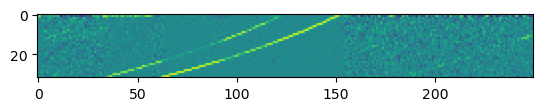

In [9]:
#View a sample of the data
i=10
print (labels_subset[i])
plt.imshow(data_norm[i,:,:])

In [11]:
#Calculate higher order statistics to be used as features
from scipy.stats import kurtosis, skew
features = np.zeros([data_collapsed.shape[0], 4])
features[:,0] = np.mean(data_collapsed, axis=1)
features[:,1] = np.std(data_collapsed, axis=1)
features[:,2] = kurtosis(data_collapsed, axis=1)
features[:,3] = skew(data_collapsed, axis=1)

nfeatures = features.shape[1]
npts = features.shape[0]

# normalize the data between 0 and 2pi
features -= features.min(0)
features /= features.max(0)
features *= 1

# make int labels
labels_subset = np.array(labels_subset.astype(int), requires_grad=False)

features = np.array(features, requires_grad=False)

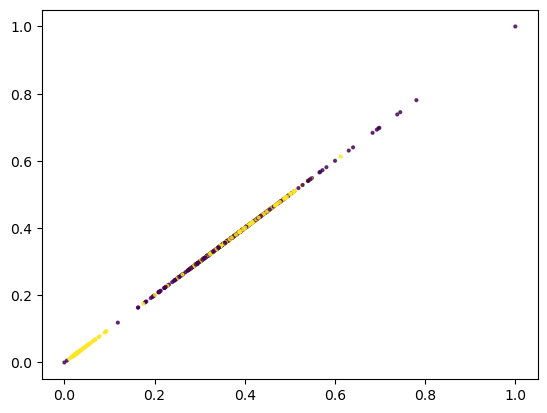

In [12]:
# Divide data into train/test
from dataset import DataSet, divide_dataset

dataset = DataSet(npts = npts, features= features[:,0:3], labels= labels_subset)

# divide the dataset in train/test
train_dataset, test_dataset = divide_dataset(dataset, shuffle=True)

# label
label_0 = [[1], [0]]
label_1 = [[0], [1]]
state_labels = np.array([label_0, label_1], requires_grad=False)

# plot the data
plt.scatter(train_dataset.features[:,2],train_dataset.features[:,2],c=train_dataset.labels,alpha=0.75,s=4)
# plt.scatter(test_dataset.features[:,0],test_dataset.features[:,1],c=test_dataset.labels)

Simple classifier with data reloading and fidelity loss
=======================================================


In [65]:
dev = qml.device("default.qubit", wires=1)
# Install any pennylane-plugin to run on some particular backend


@qml.qnode(dev)
def qcircuit(params, x, y):
    """A variational quantum circuit representing the Universal classifier.

    Args:
        params (array[float]): array of parameters
        x (array[float]): single input vector
        y (array[float]): single output state density matrix

    Returns:
        float: fidelity between output state and input
    """
    
    n_inp_bloc = -(len(x)//-3)
    
    for p in params:
        for i in range(n_inp_bloc):
            qml.Rot(*x[i*3:(i+1)*3], wires=0)
        qml.Rot(*p, wires=0)
    return qml.expval(qml.Hermitian(y, wires=[0]))


def cost(params, x, y, state_labels=None):
    """Cost function to be minimized.

    Args:
        params (array[float]): array of parameters
        x (array[float]): 2-d array of input vectors
        y (array[float]): 1-d array of targets
        state_labels (array[float]): array of state representations for labels

    Returns:
        float: loss value to be minimized
    """
    # Compute prediction for each input in data batch
    loss = 0.0
    dm_labels = [density_matrix(s) for s in state_labels]
    for i in range(len(x)):
        f = qcircuit(params, x[i], dm_labels[y[i]])
        loss = loss + (1 - f) ** 2
    return loss / len(x)

Utility functions for testing and creating batches
==================================================


In [113]:
def test(params, x, y, state_labels=None):
    """
    Tests on a given set of data.

    Args:
        params (array[float]): array of parameters
        x (array[float]): 2-d array of input vectors
        y (array[float]): 1-d array of targets
        state_labels (array[float]): 1-d array of state representations for labels

    Returns:
        predicted (array([int]): predicted labels for test data
        output_states (array[float]): output quantum states from the circuit
    """
    fidelity_values = []
    dm_labels = [density_matrix(s) for s in state_labels]
    predicted = []

    for i in range(len(x)):
        fidel_function = lambda y: qcircuit(params, x[i], y)
        fidelities = [fidel_function(dm) for dm in dm_labels]
        best_fidel = np.argmax(fidelities)

        predicted.append(best_fidel)
        fidelity_values.append(fidelities)

    return np.array(predicted), np.array(fidelity_values)


def accuracy_score(y_true, y_pred):
    """Accuracy score.

    Args:
        y_true (array[float]): 1-d array of targets
        y_predicted (array[float]): 1-d array of predictions
        state_labels (array[float]): 1-d array of state representations for labels

    Returns:
        score (float): the fraction of correctly classified samples
    """
    score = y_true == y_pred
    precision, recall, fscore, _ = precision_recall_fscore_support(y_true, y_pred)
    
    return score.sum() / len(y_true), fscore, precision, recall


def iterate_minibatches(inputs, targets, batch_size):
    """
    A generator for batches of the input data

    Args:
        inputs (array[float]): input data
        targets (array[float]): targets

    Returns:
        inputs (array[float]): one batch of input data of length `batch_size`
        targets (array[float]): one batch of targets of length `batch_size`
    """
    for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield inputs[idxs], targets[idxs]
        
# Define output labels as quantum state vectors
def density_matrix(state):
    """Calculates the density matrix representation of a state.

    Args:
        state (array[complex]): array representing a quantum state vector

    Returns:
        dm: (array[complex]): array representing the density matrix
    """
    return state * np.conj(state).T

Train a quantum classifier on the circle dataset
================================================


In [67]:
def pad_data(data):
    if data.shape[1]%3 != 0:
        nadd = 3-data.shape[1]%3
        data = np.hstack((data, np.zeros((data.shape[0], nadd), requires_grad=False)))
    return data

In [68]:
# Generate training and test data with padding (as a multiple of 3)
X_train = pad_data(train_dataset.features)
y_train = train_dataset.labels


X_test = pad_data(test_dataset.features)
y_test = test_dataset.labels

In [127]:
# Train using Adam optimizer and evaluate the classifier
num_layers = 5
learning_rate = 0.5
epochs = 20
batch_size = 64

opt = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)

# initialize random weights
params = np.random.uniform(size=(num_layers, 3), requires_grad=True)

predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
accuracy_train, f1_train, precision_train, recall_train = accuracy_score(y_train, predicted_train)

predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
accuracy_test, f1_test, precision_test, recall_test = accuracy_score(y_test, predicted_test)

# save predictions with random weights for comparison
initial_predictions = predicted_test

loss = cost(params, X_test, y_test, state_labels)

print(
    "Epoch: {:2d} | Cost:  {:3f}| Train accuracy: {:3f} | Train F1: {:3f} {:3f} | Train Precision: {:3f} {:3f} | Train Recall: {:3f} {:3f} | \
        Test Accuracy: {:3f} | Test F1: {:3f} {:3f} | Test Precision:  {:3f} {:3f} \
        | Test Recall:  {:3f} {:3f}".format(0, loss, accuracy_train, f1_train[0], f1_train[1], precision_train[0], precision_train[1], recall_train[0], recall_train[1], 
                                            accuracy_test, f1_test[0], f1_test[1], precision_test[0], precision_test[1], recall_test[0], recall_test[1]
    )
)

for it in range(epochs):
    for Xbatch, ybatch in iterate_minibatches(X_train, y_train, batch_size=batch_size):
        params, _, _, _ = opt.step(cost, params, Xbatch, ybatch, state_labels)

    predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
    accuracy_train, f1_train, precision_train, recall_train = accuracy_score(y_train, predicted_train)
    loss = cost(params, X_train, y_train, state_labels)

    predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
    accuracy_test, f1_test, precision_test, recall_test = accuracy_score(y_test, predicted_test)
    res = [it + 1, loss, accuracy_train, f1_train[0], f1_train[1], precision_train[0], precision_train[1], recall_train[0], recall_train[1],
          accuracy_test, f1_test[0], f1_test[1], precision_test[0], precision_test[1], recall_test[0], recall_test[1]]
    print(
        "Epoch: {:2d} | Cost:  {:3f}| Train accuracy: {:3f} | Train F1: {:3f} {:3f} | Train Precision: {:3f} {:3f} | Train Recall: {:3f} {:3f} | Test Accuracy: {:3f} | Test F1: {:3f} {:3f} | Test Precision:  {:3f} {:3f} | Test Recall:  {:3f} {:3f}".format(*res
        )
    )

/home/cpranav93/miniconda3/envs/frb/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cpranav93/miniconda3/envs/frb/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch:  0 | Cost:  0.453774| Train accuracy: 0.493304 | Train F1: 0.660688 0.000000 | Train Precision: 0.493304 0.000000 | Train Recall: 1.000000 0.000000 |         Test Accuracy: 0.526786 | Test F1: 0.690058 0.000000 | Test Precision:  0.526786 0.000000         | Test Recall:  1.000000 0.000000
Epoch:  1 | Cost:  0.315210| Train accuracy: 0.418527 | Train F1: 0.011385 0.588142 | Train Precision: 0.035294 0.458693 | Train Recall: 0.006787 0.819383 |         Test Accuracy: 0.410714 | Test F1: 0.000000 0.582278 | Test Precision:  0.000000 0.438095         | Test Recall:  0.000000 0.867925


/home/cpranav93/miniconda3/envs/frb/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch:  2 | Cost:  0.267426| Train accuracy: 0.491071 | Train F1: 0.658683 0.000000 | Train Precision: 0.492170 0.000000 | Train Recall: 0.995475 0.000000 |         Test Accuracy: 0.526786 | Test F1: 0.690058 0.000000 | Test Precision:  0.526786 0.000000         | Test Recall:  1.000000 0.000000
Epoch:  3 | Cost:  0.236692| Train accuracy: 0.491071 | Train F1: 0.562380 0.392000 | Train Precision: 0.488333 0.496622 | Train Recall: 0.662896 0.323789 |         Test Accuracy: 0.450893 | Test F1: 0.552727 0.289017 | Test Precision:  0.484076 0.373134         | Test Recall:  0.644068 0.235849
Epoch:  4 | Cost:  0.281091| Train accuracy: 0.580357 | Train F1: 0.700159 0.301115 | Train Precision: 0.540640 0.964286 | Train Recall: 0.993213 0.178414 |         Test Accuracy: 0.589286 | Test F1: 0.719512 0.233333 | Test Precision:  0.561905 1.000000         | Test Recall:  1.000000 0.132075
Epoch:  5 | Cost:  0.238757| Train accuracy: 0.514509 | Train F1: 0.355556 0.610564 | Train Precision: 0.5150

Results
=======


Epoch:  0 | Cost:  0.220784| Train accuracy: 0.609375 | Train F1: 0.612832 0.605856 | Train Precision: 0.599567 0.619816 | Train Recall: 0.626697 0.592511 |         Test Accuracy: 0.656250 | Test F1: 0.666667 0.645161 | Test Precision:  0.681416 0.630631         | Test Recall:  0.652542 0.660377
Learned weights
Layer 0: [1.96656076 2.6733955  5.73415727]
Layer 1: [ 6.59580225 -1.75394547  4.3140833 ]
Layer 2: [ 5.1638121  -0.62789026  6.60264871]
Layer 3: [ 5.67825248  0.88460362 -0.45066315]
Layer 4: [0.01901689 3.30791257 0.91861883]


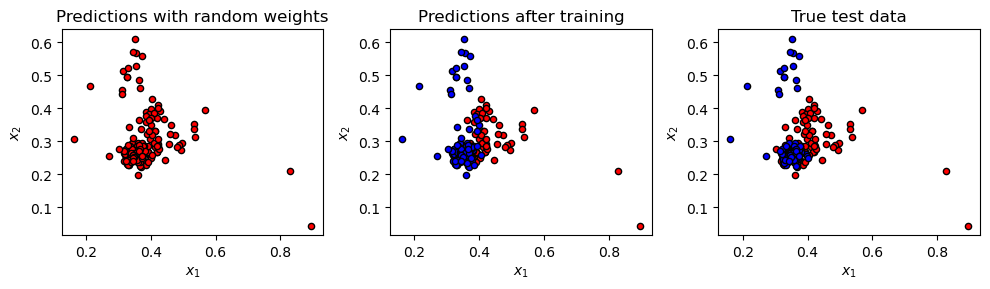

In [128]:
print(
    "Epoch: {:2d} | Cost:  {:3f}| Train accuracy: {:3f} | Train F1: {:3f} {:3f} | Train Precision: {:3f} {:3f} | Train Recall: {:3f} {:3f} | \
        Test Accuracy: {:3f} | Test F1: {:3f} {:3f} | Test Precision:  {:3f} {:3f} \
        | Test Recall:  {:3f} {:3f}".format(0, loss, accuracy_train, f1_train[0], f1_train[1], precision_train[0], precision_train[1], recall_train[0], recall_train[1], 
                                            accuracy_test, f1_test[0], f1_test[1], precision_test[0], precision_test[1], recall_test[0], recall_test[1]
    )
)

print("Learned weights")
for i in range(num_layers):
    print("Layer {}: {}".format(i, params[i]))

    
def plot_data(x, y, fig=None, ax=None):
    """
    Plot data with red/blue values for a binary classification.

    Args:
        x (array[tuple]): array of data points as tuples
        y (array[int]): array of data points as tuples
    """
    if fig == None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    reds = y == 0
    blues = y == 1
    ax.scatter(x[reds, 0], x[reds, 1], c="red", s=20, edgecolor="k")
    ax.scatter(x[blues, 0], x[blues, 1], c="blue", s=20, edgecolor="k")
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    

fig, axes = plt.subplots(1, 3, figsize=(10, 3))
plot_data(X_test, initial_predictions, fig, axes[0])
plot_data(X_test, predicted_test, fig, axes[1])
plot_data(X_test, y_test, fig, axes[2])
axes[0].set_title("Predictions with random weights")
axes[1].set_title("Predictions after training")
axes[2].set_title("True test data")
plt.tight_layout()
plt.show()

### Classical DNN with 1 FC layer 

In [102]:
# Classical ML with keras
import keras

#Create model
inputs = keras.Input(shape=X_train.shape[1])
hidden_layer = keras.layers.Dense(15, activation="relu")(inputs)
output_layer = keras.layers.Dense(2, activation="softmax")(hidden_layer)
model = keras.Model(inputs=inputs, outputs = output_layer)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense_6 (Dense)             (None, 15)                60        
                                                                 
 dense_7 (Dense)             (None, 2)                 32        
                                                                 
Total params: 92
Trainable params: 92
Non-trainable params: 0
_________________________________________________________________


In [103]:
#Compile the model
model.compile(optimizer='adam', loss=keras.losses.CategoricalCrossentropy())

In [104]:
#Create one-hot vector of labels
num_classes=2
y_train_1hot = keras.utils.to_categorical(y_train, num_classes)
y_train_1hot

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [105]:
#Train the model
history = model.fit(X_train, y_train_1hot, epochs=100)

Epoch 1/100
28/28 [==============================] - 0s 2ms/step - loss: 0.6874
Epoch 2/100
28/28 [==============================] - 0s 2ms/step - loss: 0.6838
Epoch 3/100
28/28 [==============================] - 0s 2ms/step - loss: 0.6818
Epoch 4/100
28/28 [==============================] - 0s 2ms/step - loss: 0.6789
Epoch 5/100
28/28 [==============================] - 0s 2ms/step - loss: 0.6766
Epoch 6/100
28/28 [==============================] - 0s 2ms/step - loss: 0.6745
Epoch 7/100
28/28 [==============================] - 0s 2ms/step - loss: 0.6733
Epoch 8/100
28/28 [==============================] - 0s 2ms/step - loss: 0.6717
Epoch 9/100
28/28 [==============================] - 0s 2ms/step - loss: 0.6699
Epoch 10/100
28/28 [==============================] - 0s 2ms/step - loss: 0.6685
Epoch 11/100
28/28 [==============================] - 0s 2ms/step - loss: 0.6673
Epoch 12/100
28/28 [==============================] - 0s 2ms/step - loss: 0.6660
Epoch 13/100
28/28 [=================

In [106]:
#Test model prediction
import tensorflow as tf
y_pred = model.predict(X_test)
predicted_test = np.array(tf.argmax(y_pred, axis = 1))
predicted_test

7/7 [==============================] - 0s 1ms/step


tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1,
        0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1,
        0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
        0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1,
        0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0,
        1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0,
        0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1,
        0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 1, 0], requires_grad=True)

In [125]:
accuracy_test_ml, f1_test_ml, precision_test_ml, recall_test_ml = accuracy_score(y_test, predicted_test)
print(
    "Test Accuracy: {:3f} | Test F1:  {:3f}  {:3f}  | Test Precision:  {:3f}  {:3f} | Test Recall:  {:3f}  {:3f} ".format(accuracy_test_ml, 
            f1_test_ml[0], f1_test_ml[1], precision_test_ml[0],  precision_test_ml[1], recall_test_ml[0], recall_test_ml[1])
)

Test Accuracy: 0.415179 | Test F1:  0.000000  0.586751  | Test Precision:  0.000000  0.440758 | Test Recall:  0.000000  0.877358 


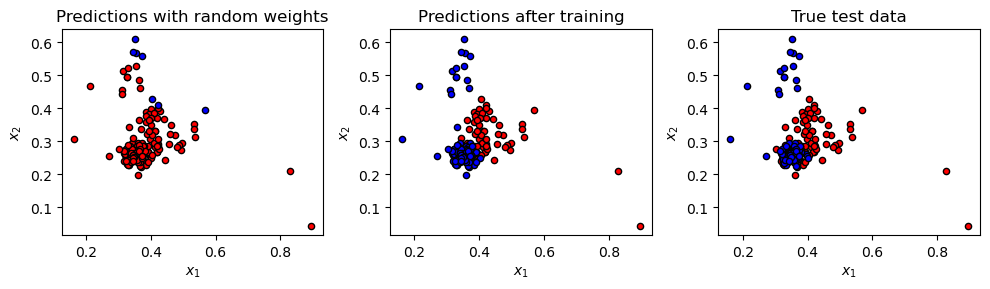

In [94]:
def plot_data(x, y, fig=None, ax=None):
    """
    Plot data with red/blue values for a binary classification.

    Args:
        x (array[tuple]): array of data points as tuples
        y (array[int]): array of data points as tuples
    """
    if fig == None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    reds = y == 0
    blues = y == 1
    ax.scatter(x[reds, 0], x[reds, 1], c="red", s=20, edgecolor="k")
    ax.scatter(x[blues, 0], x[blues, 1], c="blue", s=20, edgecolor="k")
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    

fig, axes = plt.subplots(1, 3, figsize=(10, 3))
plot_data(X_test, initial_predictions, fig, axes[0])
plot_data(X_test, predicted_test, fig, axes[1])
plot_data(X_test, y_test, fig, axes[2])
axes[0].set_title("Predictions with random weights")
axes[1].set_title("Predictions after training")
axes[2].set_title("True test data")
plt.tight_layout()
plt.show()

References
==========

\[1\] Pérez-Salinas, Adrián, et al. "Data re-uploading for a universal
quantum classifier." arXiv preprint arXiv:1907.02085 (2019).

\[2\] Kingma, Diederik P., and Ba, J. "Adam: A method for stochastic
optimization." arXiv preprint arXiv:1412.6980 (2014).

\[3\] Liu, Dong C., and Nocedal, J. "On the limited memory BFGS method
for large scale optimization." Mathematical programming 45.1-3 (1989):
503-528.
